## Single-label multiclass classification problem
The Reuters dataset, containing short newswires and their topics published by Reuters in 1986, is used as a simple toy dataset for text classification. The dataset contains 46 different topics with each topic having at least 10 exmaples.

In [1]:
from keras.datasets import reuters
# Restricting data to 10,000 most frequently occurring words.
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

Using TensorFlow backend.


2113536/2110848 [==============================] - 0s 0us/step


In [2]:
print(len(train_data))
print(len(test_data))

8982
2246


In [3]:
# Similar to the imdb dataset, each example is a list of integers, 
# where each integer is an index in a dictionary of words.
print(train_data[10])

[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]


In [4]:
# Decoding an example back to text.
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i-3, '?') for i in train_data[10]]) # Second arguement in dict.get() is a default value, which would be returned if the key is not found.
# The indices are offset by 3 because:
# 0, 1, and 2 are reserved indices for “padding,” “start of sequence,” and “unknown.”
print(decoded_newswire)

557056/550378 [==============================] - 0s 0us/step
? period ended december 31 shr profit 11 cts vs loss 24 cts net profit 224 271 vs loss 511 349 revs 7 258 688 vs 7 200 349 reuter 3


In [5]:
# Similarly, the label assiciated with each example is an integer between 0 and 45 (the label index).
print(train_labels[10])

3


In [6]:
print(max(reverse_word_index.keys()))

30979


In [7]:
# Vectorize the data using one-hot encoding
import numpy as np

def vectorize_sequences(sequences, dimensions=10000):
    results = np.zeros((len(sequences), dimensions))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [8]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

### Vectorize labels
To vectorize labels, there are two options: (1) cast the label list as integer tensor or (2) use one-hot encoding. The latter option is a widely-used format for categorical data and is called the **categorical encoding**.

The code below shows how to perform the one-hot encoding on the labels. However, we can directly use the util provided by keras, as shown in the next two cells.

In [9]:
def to_one_hot(labels, dimensions=46):
    results = np.zeros((len(labels), dimensions))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results
one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

In [10]:
from keras.utils.np_utils import to_categorical
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [11]:
# Define the model.
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

In [12]:
# Compile the model.
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [13]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [14]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=20,
                   batch_size=512,
                   validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 135us/step - loss: 2.7224 - accuracy: 0.4589 - val_loss: 1.8440 - val_accuracy: 0.6140
Epoch 2/20
7982/7982 [==============================] - 1s 95us/step - loss: 1.4929 - accuracy: 0.6787 - val_loss: 1.3504 - val_accuracy: 0.7000
Epoch 3/20
7982/7982 [==============================] - 1s 101us/step - loss: 1.0918 - accuracy: 0.7580 - val_loss: 1.1883 - val_accuracy: 0.7400
Epoch 4/20
7982/7982 [==============================] - 1s 96us/step - loss: 0.8668 - accuracy: 0.8117 - val_loss: 1.0528 - val_accuracy: 0.7720
Epoch 5/20
7982/7982 [==============================] - 1s 97us/step - loss: 0.6981 - accuracy: 0.8561 - val_loss: 1.0159 - val_accuracy: 0.7790
Epoch 6/20
7982/7982 [==============================] - 1s 102us/step - loss: 0.5615 - accuracy: 0.8836 - val_loss: 0.9372 - val_accuracy: 0.8170
Epoch 7/20
7982/7982 [==============================] - 1s 95us/step - loss: 0.

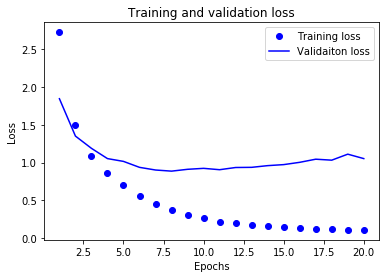

In [15]:
# Plott the training and validation loss.
%matplotlib inline
import matplotlib.pyplot as plt
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validaiton loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

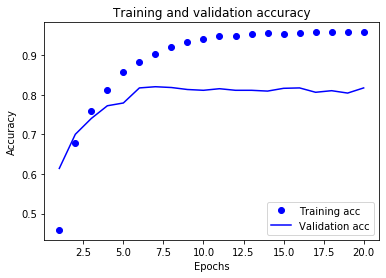

In [17]:
# Plot the training and validation accuracy.
plt.clf()
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Analyzing the above plots:
The network starts to overfit after nine epochs. Let's train the network from scratch for nine epochs and then evaluate it on the test data.

In [18]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train,
          one_hot_train_labels,
          epochs=9,
          batch_size=512,
          )
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
8982/8982 [==============================] - 1s 98us/step - loss: 2.4594 - accuracy: 0.5491
Epoch 2/9
8982/8982 [==============================] - 1s 93us/step - loss: 1.3218 - accuracy: 0.7147
Epoch 3/9
8982/8982 [==============================] - 1s 84us/step - loss: 0.9904 - accuracy: 0.7851
Epoch 4/9
8982/8982 [==============================] - 1s 93us/step - loss: 0.7757 - accuracy: 0.8320
Epoch 5/9
8982/8982 [==============================] - 1s 87us/step - loss: 0.6118 - accuracy: 0.8671
Epoch 6/9
8982/8982 [==============================] - 1s 90us/step - loss: 0.4871 - accuracy: 0.8961
Epoch 7/9
8982/8982 [==============================] - 1s 87us/step - loss: 0.3895 - accuracy: 0.9161
Epoch 8/9
8982/8982 [==============================] - 1s 91us/step - loss: 0.3196 - accuracy: 0.9297
Epoch 9/9
2246/2246 [==============================] - 0s 162us/step


In [19]:
print(results)

[0.9809288594304507, 0.7938557267189026]


In [20]:
# To see how good the results are, we compare the classification accuracy, 
# i.e., 79.47% with that of a random classifier.
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
print(float(np.sum(hits_array)) / len(test_labels))

0.18744434550311664


### Takeaway: 
Our classifier performs significantly better than a truely random classifier (~80% vs ~18%)

In [21]:
# Generating predictions from the trained model.
predictions = model.predict(x_test)

In [22]:
print(predictions.shape)

(2246, 46)


In [24]:
print(np.sum(predictions[0])) # Probabilities: sum to 1.

0.9999998


In [25]:
# The largest entry (class with highest probability) is the predicted class.
print(np.argmax(predictions[0]))

3


In [26]:
# A different way to handle the labels and the loss:
# Cast labels as integer tensor and use 'sparse_categorical_crossentropy' as loss function
#y_train = np.array(train_labels)
#y_test = np.array(test_labels)
# Create model
#model.compile(optimizer='rmsprop',
#             loss='sparse_categorical_crossentropy',
#             metrics=['accuracy'])